In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graph_tool.all as gt
import sys
# sys.insert_path('/Users/glover.co/Documents/laszlo/NetDesign/scripts/')
import assembly_tree as at
import mcmc
import treelib
from itertools import product

In [80]:
X = np.vstack([np.eye(3) for i in range(2)])
O = np.array([[0,1,1],[1,0,1],[1,1,2]])
capacity = O.sum(axis=1,dtype=int)
target = nx.Graph()
target.add_nodes_from(np.arange(6))
target.add_edges_from([[0,1],[1,2],[2,0],[3,4],[4,5],[5,3],[2,5]])

In [ ]:
trees = {}
i = -1
ex0 = mcmc.AssemblyTree(target,X,O,capacity)
samples = ex0.Tree.get_node(0).data.subgraph
p = 0
for j,h in enumerate(samples):
    if nx.is_isomorphic(h, target):
        p += ex0.Tree.get_node(0).data.p[j]
trees[i] = p
for i in range(100):
    ex0.update_tree()
    samples = ex0.Tree.get_node(0).data.subgraph
    p = 0
    for j,h in enumerate(samples):
        if nx.is_isomorphic(h, target):
            p += ex0.Tree.get_node(0).data.p[j]
    trees[i] = p



here
[Node(tag=2, identifier=2, data=<mcmc.AssemblyNode object at 0x303b082d0>), Node(tag=4, identifier=4, data=<mcmc.AssemblyNode object at 0x302f39f50>), Node(tag=5, identifier=5, data=<mcmc.AssemblyNode object at 0x160f31c50>), Node(tag=6, identifier=6, data=<mcmc.AssemblyNode object at 0x160f316d0>)]
Node(tag=2, identifier=2, data=<mcmc.AssemblyNode object at 0x303b082d0>)
here
Node(tag=4, identifier=4, data=<mcmc.AssemblyNode object at 0x302f39f50>)
here
Node(tag=5, identifier=5, data=<mcmc.AssemblyNode object at 0x160f31c50>)
here
Node(tag=6, identifier=6, data=<mcmc.AssemblyNode object at 0x160f316d0>)
here


[0.1 0.1 0.1 0.7]


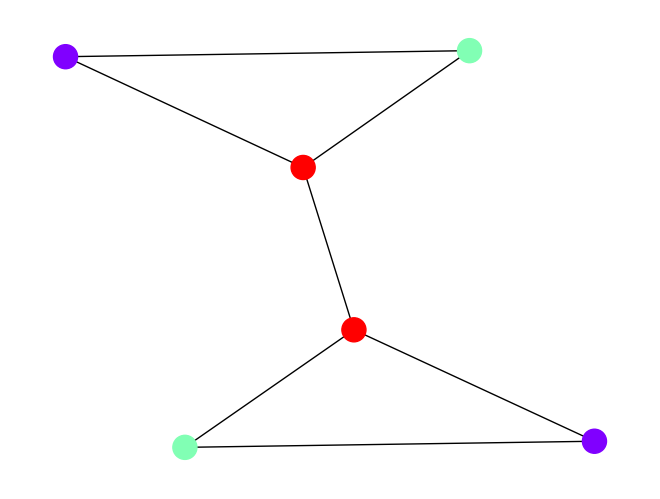

In [86]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],ex0.X)
print(ex0.Tree.get_node(0).data.p)

In [30]:
ex0.update_tree(dist=[1,0,0,0])

[Node(tag=1, identifier=1, data=<mcmc.AssemblyNode object at 0x302f5eb70>), Node(tag=2, identifier=2, data=<mcmc.AssemblyNode object at 0x161003cb0>)]
Node(tag=1, identifier=1, data=<mcmc.AssemblyNode object at 0x302f5eb70>)
here
Node(tag=2, identifier=2, data=<mcmc.AssemblyNode object at 0x161003cb0>)
here
Node(tag=0, identifier=0, data=<mcmc.AssemblyNode object at 0x10e5a69c0>)
Node(tag=0, identifier=0, data=<mcmc.AssemblyNode object at 0x10e5a69c0>)


In [31]:
ex0.Tree.get_node(0).data.p
# ex0.merge(0)

[np.float64(0.06), 0, 0, 0, 0, 0, 0, 0, 0, 0]

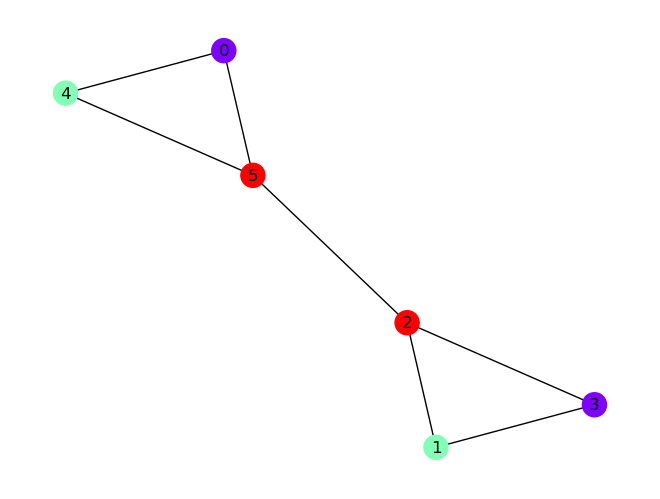

In [34]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],ex0.X,with_labels=True)

In [38]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[1],ex0.X)

IndexError: list index out of range

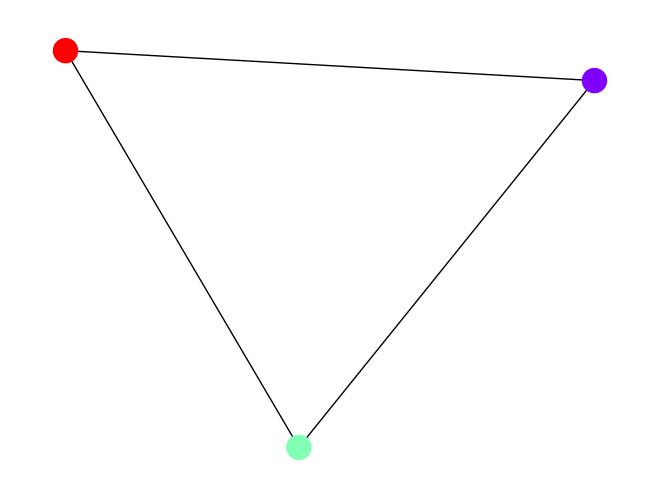

In [40]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[0],ex0.X)

In [26]:
sum(ex0.Tree.get_node(0).data.p)

np.float64(0.006)

In [25]:
sub_nodes

[np.int64(3), np.int64(2)]

In [60]:
g = nx.Graph()
g.add_nodes_from(np.arange(6))
p, samples, idx = at.prob_dist(X,O,capacity,initial_graph=g,max_edges=True,labeled=False,max_iters=100)

In [32]:
true_A = ex0.target_A[:,sub_nodes][sub_nodes,:]
cur_a = nx.adjacency_matrix(samples[0]).todense()
np.allclose(true_A,cur_a)

False

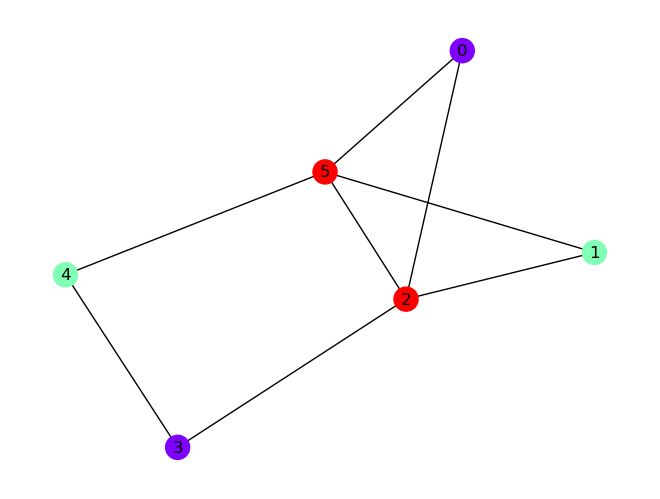

In [65]:
at.draw_network(samples[3],X,with_labels=True)

In [61]:
p

array([ 2,  5,  1, 92])

In [ ]:
children = ex0.Tree.get_node(0).successors(ex0.Tree.identifier)

In [56]:
zero_prob = np.prod(np.array([np.prod(x) for c in children for x in ex0.Tree.get_node(c).data.logP ]))

In [63]:
subgraph_list = [ex0.Tree.get_node(c).data.subgraph for c in children]

In [64]:
subgraph_list

[[],
 [],

In [9]:
x = 1
y = 2
z = 3
true_list = [x,y,z]
for j, s in enumerate(true_list):
    true_list[j] = 4

In [70]:
list1 = [1,2,3,4,5,6]
list2 = [4,5,6,7]
list3 = [2,1]

In [71]:
from itertools import product

In [74]:
np.prod(list(product(list1, list2, list3)),axis=1)

array([ 8,  4, 10,  5, 12,  6, 14,  7, 16,  8, 20, 10, 24, 12, 28, 14, 24,
       12, 30, 15, 36, 18, 42, 21, 32, 16, 40, 20, 48, 24, 56, 28, 40, 20,
       50, 25, 60, 30, 70, 35, 48, 24, 60, 30, 72, 36, 84, 42])